In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import re

In [2]:
train = pd.read_csv('./training_set.csv')
train = train.drop(columns=['Unnamed: 0'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      3910 non-null   float64
 1   X2      3910 non-null   float64
 2   X3      3910 non-null   float64
 3   X4      3910 non-null   float64
 4   X5      3910 non-null   float64
 5   X6      3910 non-null   float64
 6   X7      3910 non-null   float64
 7   X8      3910 non-null   float64
 8   X9      3910 non-null   float64
 9   X10     3910 non-null   float64
 10  X11     3910 non-null   float64
 11  X12     3910 non-null   float64
 12  X13     3910 non-null   float64
 13  X14     3910 non-null   float64
 14  X15     3910 non-null   float64
 15  X16     3910 non-null   float64
 16  X17     3910 non-null   float64
 17  X18     3910 non-null   float64
 18  X19     3910 non-null   float64
 19  X20     3910 non-null   float64
 20  X21     3910 non-null   float64
 21  X22     3910 non-null   float64
 22  

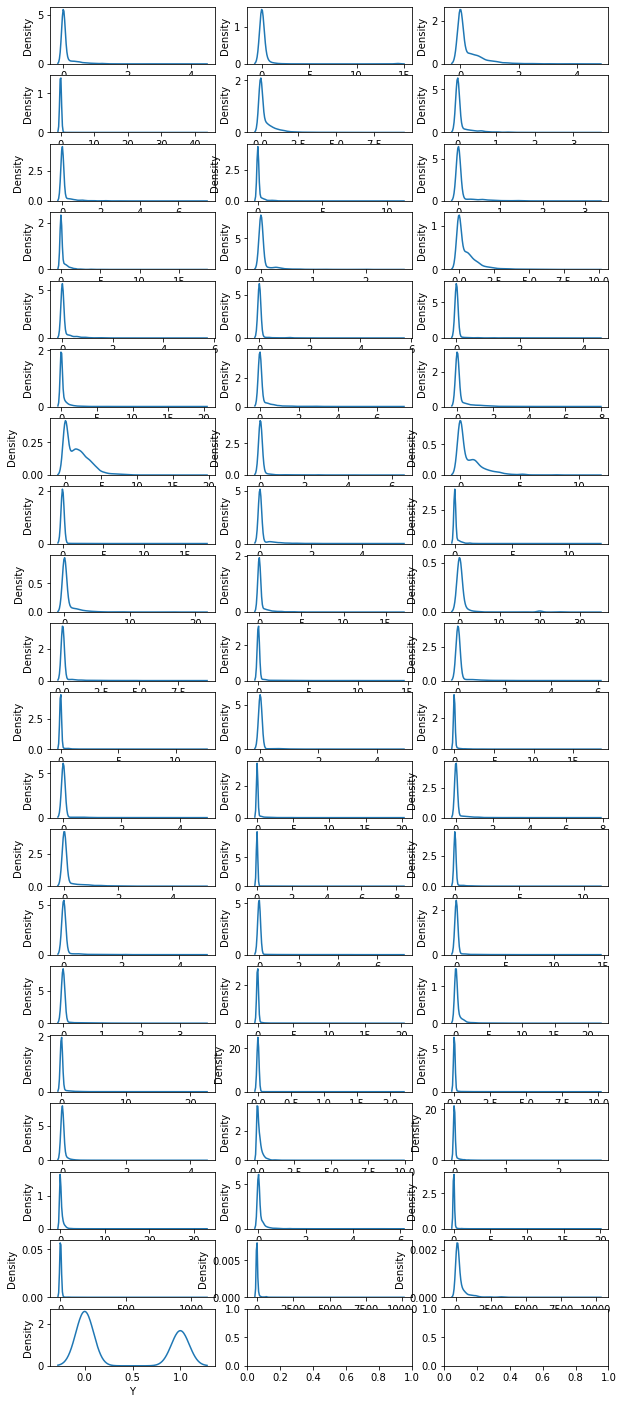

In [4]:
fig,ax = plt.subplots(nrows=20,ncols=3,figsize=(10,25))

l = 0
for i in range(20):
    for j in range(3):
        try:
            sns.kdeplot(train[train.columns[l]], ax=ax[i][j])
            l += 1
        except:
            break

# Feature Selection / Dimensionality Reduction

I have tried several methods for feature selection and the summary of the methods are outlined below:

1. Univariate Feature Selection
    - Multicollinearity Analysis Using Heat map and VIF
    - ANOVA correlation coefficient
    - Mututal Information 
2. Recursive Feature Elimination (Top down approach)
    - Logistic Regression
    - LinearSVC
3. Sequential Feature Selection (Bottom up approach)
    - KNeighborsClassifier
    - Tree based Models
4. Principal Componenet Analysis (PCA)

## 1.A Multicolinearity Analysis Using Correlation Matrix and VIF

Text(0.5, 1.0, 'Correlation Heatmap')

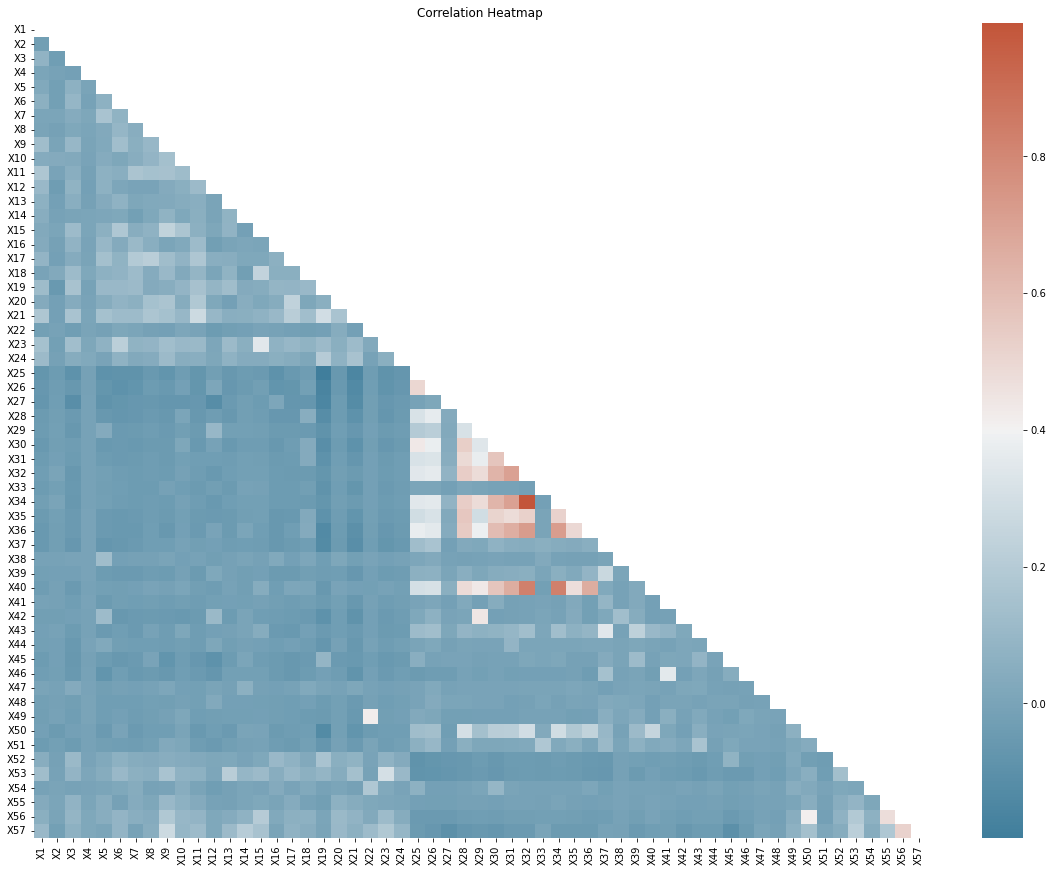

In [5]:
corr = train.drop(columns=['Y']).corr()
f, ax = plt.subplots(figsize=(20, 15))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=False, mask = mask, cmap=cmap)
plt.title('Correlation Heatmap')

From the above plot we see that Features X34 and X32 are highly correlated, and also X40 is correlated with X32 and X34, For regression analysis it is important to drop highly correlated columns and hence I have decided to drop X34 for further analysis, I also confirm the same observation by calculating VIF where we regress each column with all the others and confirm that X34 and X32 are having high VIF values and hence can be dropped. It is also evident from the pair plots below.

Text(0.5, 1.0, 'VIF plot: Columns vs VIF')

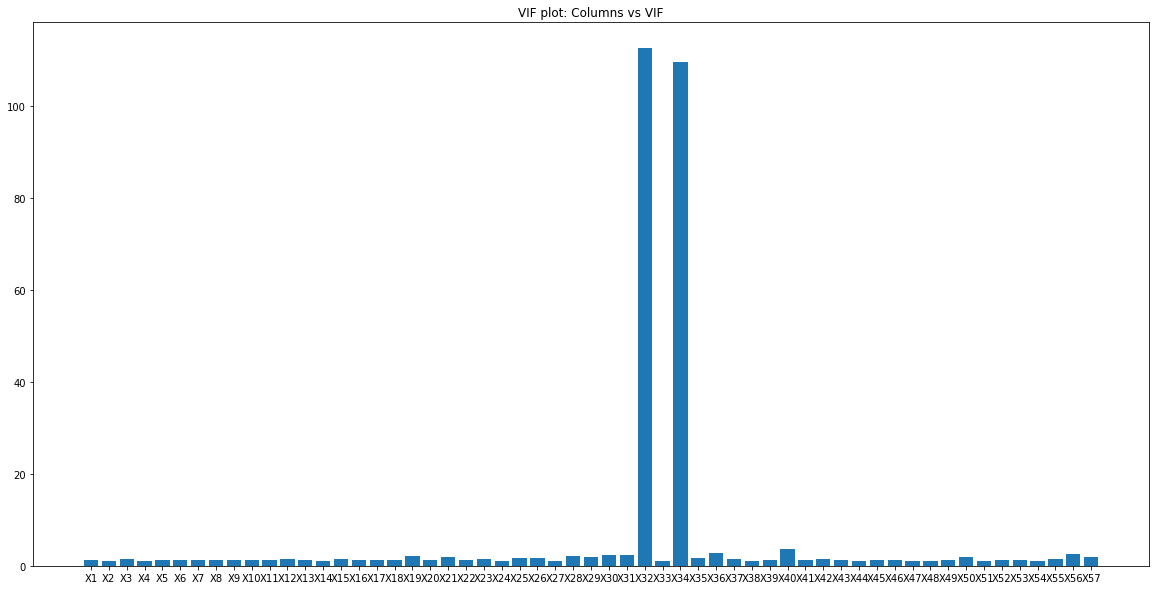

In [6]:
X = train.drop(columns=['Y'])
vif = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
cols = X.columns.values
f, ax = plt.subplots(figsize=(20, 10))
ax.bar(cols,vif)
plt.title('VIF plot: Columns vs VIF')

Text(0.5, 1.08, "'Pair plot of X32, X34 and X40'")

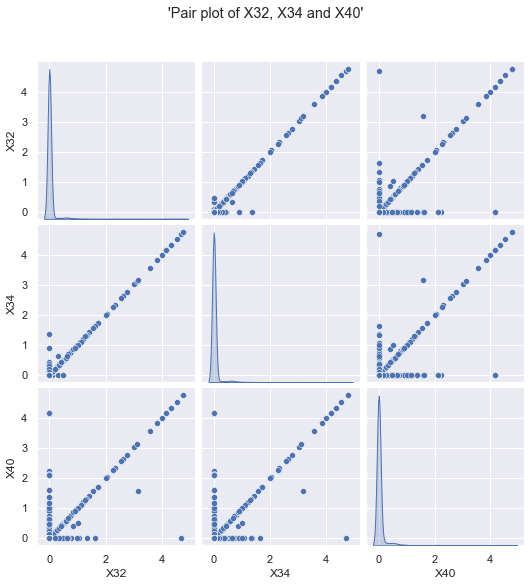

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
cData_attr = train[['X32','X34','X40']]
g = sns.pairplot(cData_attr, diag_kind='kde')
g.fig.suptitle("'Pair plot of X32, X34 and X40'", y=1.08)

In [8]:
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
train = train.drop(columns=to_drop)
train.shape

(3910, 57)

## 1.B, 1.C ANNOVA and Mutual Information

Text(0.5, 1.0, 'Plot representing the level of significance of 30 best features using ANOVA')

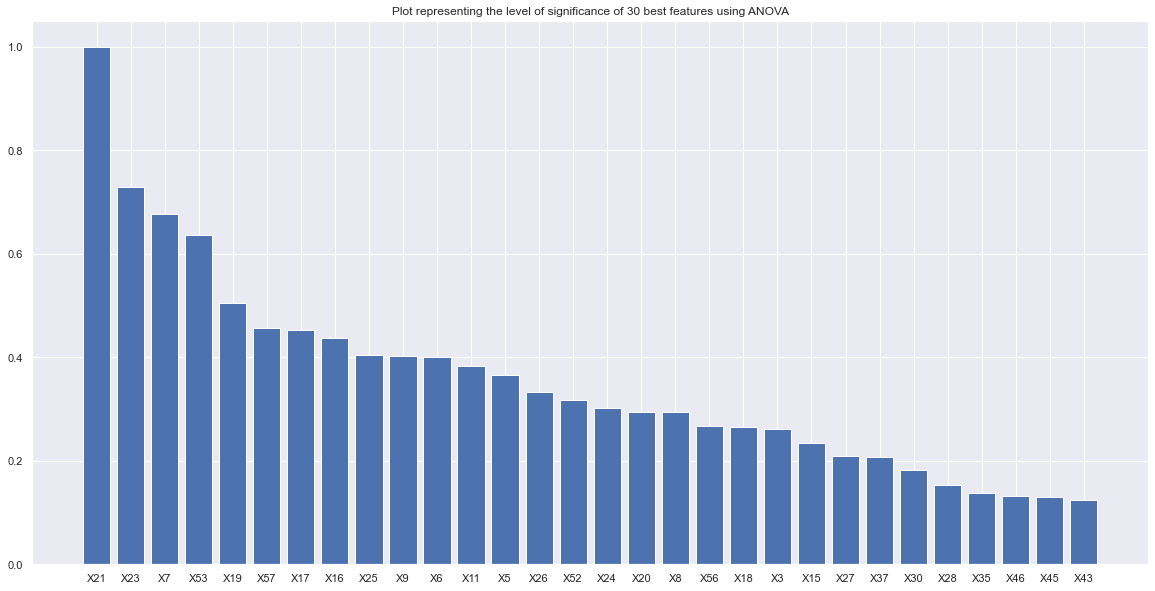

In [9]:
X = train.drop(columns=['Y'])
y = train['Y']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4535, stratify=y, shuffle=True)

# Let us select 30 features
select = SelectKBest(f_classif, k=30)
select.fit(X, y)
scores = -np.log10(select.pvalues_)
scores /= scores.max()

feature_importance = list(zip(X_train.columns.values, scores))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]

f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Plot representing the level of significance of 30 best features using ANOVA')

Text(0.5, 1.0, 'Plot representing the level of significance of 30 best features using Mutual Information')

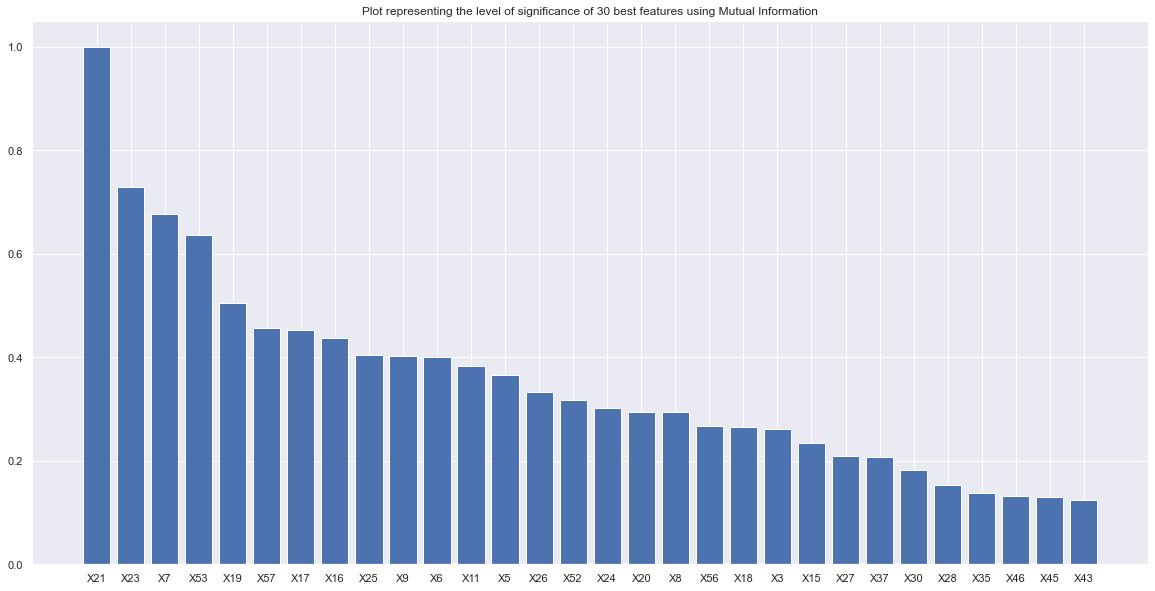

In [10]:
#30 best features according to Mutual information
select = SelectKBest(mutual_info_classif, k=30)
select.fit(X, y)
scores /= scores.max()

feature_importance = list(zip(X_train.columns.values, scores))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]

f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Plot representing the level of significance of 30 best features using Mutual Information')

## 2.A Recursive Feature Elimination using weights of Logistic Regression Model

Text(0.5, 1.0, 'Selected Features according to RFE and Logistic Regression')

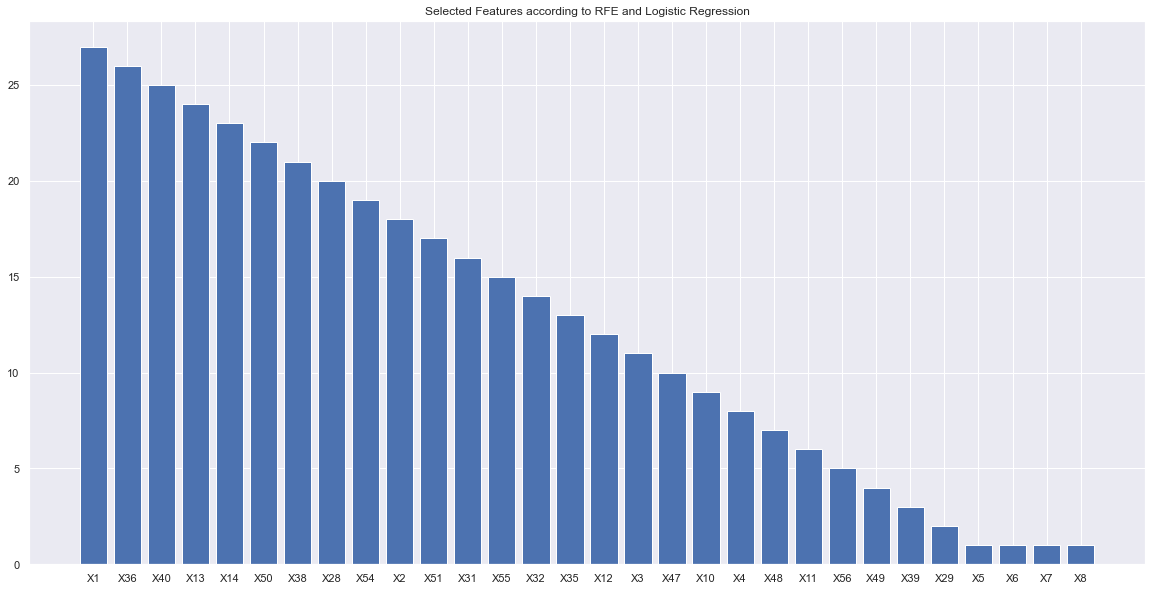

In [11]:
scaled_X = MinMaxScaler().fit_transform(X)
estimator = LogisticRegression()
selectorr = RFE(estimator,n_features_to_select=30, step=1)
selectorr = selectorr.fit(scaled_X, y)
rank = selectorr.ranking_

feature_importance = list(zip(X_train.columns.values, rank))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]
f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Selected Features according to RFE and Logistic Regression')

Text(0.5, 1.0, 'Selected Features according to RFE and LinearSVC')

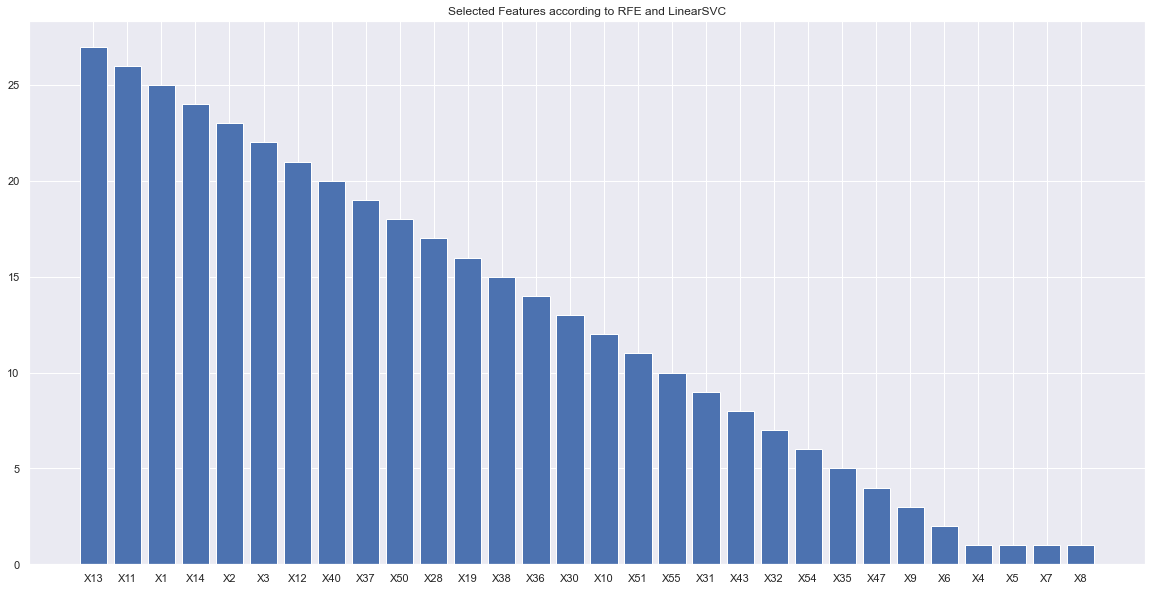

In [12]:
estimator = LinearSVC()
selectorr = RFE(estimator,n_features_to_select=30, step=1)
selectorr = selectorr.fit(scaled_X, y)
rank = selectorr.ranking_

feature_importance = list(zip(X_train.columns.values, rank))
feature_importance.sort(key = lambda x: x[1], reverse=True) 
feature_importance = [list(t) for t in zip(*feature_importance)]
f, ax = plt.subplots(figsize=(20, 10))
ax.bar(feature_importance[0][:30], feature_importance[1][:30])
plt.title('Selected Features according to RFE and LinearSVC')

## 3. Sequential Feature Selection using KNeighborsClassifier and DecisionTreeClassifier

In [13]:
%%time
estimator = KNeighborsClassifier(weights='distance')
sfs = SequentialFeatureSelector(estimator, n_features_to_select=30, n_jobs=-1, cv=2, scoring='accuracy')
sfs.fit(X, y)
fi_Neighbors = X.columns.values[sfs.support_]
fi_Neighbors

CPU times: total: 11 s
Wall time: 2min 45s


array(['X4', 'X7', 'X9', 'X15', 'X16', 'X20', 'X22', 'X23', 'X24', 'X25',
       'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X35', 'X38', 'X40',
       'X41', 'X42', 'X44', 'X46', 'X47', 'X48', 'X49', 'X51', 'X52',
       'X53', 'X54'], dtype=object)

In [14]:
%%time
estimator = DecisionTreeClassifier()
sfs = SequentialFeatureSelector(estimator, n_features_to_select=30, n_jobs=-1, cv=2, scoring='accuracy')
sfs.fit(X, y)
fi_tree_fwd = X.columns.values[sfs.support_]
fi_tree_fwd

CPU times: total: 9.23 s
Wall time: 26.6 s


array(['X1', 'X3', 'X4', 'X6', 'X7', 'X11', 'X13', 'X14', 'X15', 'X17',
       'X18', 'X22', 'X25', 'X27', 'X28', 'X29', 'X30', 'X31', 'X33',
       'X37', 'X39', 'X40', 'X42', 'X45', 'X46', 'X47', 'X48', 'X52',
       'X53', 'X56'], dtype=object)

In [15]:
%%time
from sklearn.tree import ExtraTreeClassifier
estimator = ExtraTreeClassifier()
sfs = SequentialFeatureSelector(estimator, direction='forward',n_features_to_select=30, n_jobs=-1, cv=2, scoring='accuracy')
sfs.fit(X, y)
fi_tree_bwd = X.columns.values[sfs.support_]
fi_tree_bwd

CPU times: total: 10.1 s
Wall time: 18.2 s


array(['X4', 'X5', 'X7', 'X10', 'X16', 'X17', 'X20', 'X23', 'X24', 'X25',
       'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X38', 'X39',
       'X40', 'X42', 'X43', 'X44', 'X46', 'X48', 'X49', 'X52', 'X53',
       'X55', 'X56'], dtype=object)

# PCA

In [16]:
pca = PCA(n_components=30)
pca.fit(X)
pca_x = pca.transform(X)
sum(pca.explained_variance_ratio_)

0.9999949958226336